## Inference: Differential Evolution (DE) MCMC

This example shows you how to perform Bayesian inference on a time series, using [Differential Evolution MCMC](http://pints.readthedocs.io/en/latest/mcmc/differential_evolution_mcmc.html).

It follows on from the [basic MCMC example](./inference-first-example.ipynb).

Running...
Done!


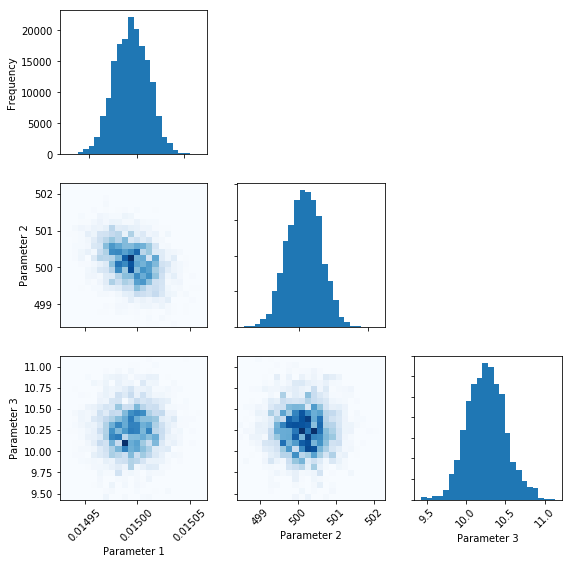

In [1]:
import sys
import os
from __future__ import print_function
import pints
import pints.toy as toy
import pints._diagnostics as diagnostics
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-posterior (prior * likelihood)
log_posterior = pints.LogPosterior(prior, log_likelihood)

# Create differential evolution MCMC routine
x0 = real_parameters * 1.1
mcmc = pints.DifferentialEvolutionMCMC(log_posterior, x0)

# Use 4000 iterations in total
mcmc.set_iterations(4000)

# Discard the first 2000 iterations as warm-up
mcmc.set_warm_up(2000)

# Store only every 4th sample
mcmc.set_thinning_rate(4)

# Disable verbose mode
mcmc.set_verbose(False)

# Set gamma
mcmc.set_gamma(0.1)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Plot output
import pints.plot # Use Pints' diagnostic tool

stacked = np.vstack(chains)
pints.plot.pairwise(stacked, kde=False)

plt.show()

In [2]:
diagnostics.rhat_all_params(chains)

[1.0266569173900661, 1.0215501175087658, 1.302782225106353]